## 数据预处理

>在21号风机的数据集中，有正常时间区间的数据、故障时间区间的数据以及无效数据，且其中正常时间区间覆盖的数据远远大于故障时间区间覆盖的数据。因此需要对无效数据进行过滤删除，以及为了防止决策树偏向于主导类，需要进行类平衡，即对正常时间区间覆盖的数据样本进行欠采样。

首先，给每个样本增添一个特征`isfailureinfo`。对故障时间区间覆盖的数据行标记为1，正常时间区间覆盖的数据行标记为0，无效数据不做标记。

In [5]:
import pandas as pd
import sys
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
data         = pd.read_csv("../datasets/DraughtFan/train/21/21_data.csv")
failure_time = pd.read_csv("../datasets/DraughtFan/train/21/21_failureInfo.csv")
normal_time  = pd.read_csv("../datasets/DraughtFan/train/21/21_normalInfo.csv")



data['isfailureinfo'] = ''              # 添加特征 isfailureinfo
test_count            = data.shape[0]   # 测试数据数 , 全部为 data.shape[0]

# 依次遍历data数据和failure数据，时间复杂度为 O(m×n)
for i in data.index:
    # 显示进度
    print("\r", end="")    
    print("进度: {}% ".format(round(i/test_count*100,2)), end="")
    sys.stdout.flush()

    data_time = pd.to_datetime(data['time'][i])
    done      = False
     # 正常时间区间数据标记
    for normal in normal_time.index:
        start_time = pd.to_datetime(normal_time['startTime'][normal])
        end_time   = pd.to_datetime(normal_time['endTime'][normal]) 
        if data_time < start_time or data_time > end_time:
            continue  # 不在区间里面，continue继续遍历
        else:         # 在区间里面，标记 isfailureinfo 特征为 0，break跳出
            data['isfailureinfo'][i] = 0
            done                     = True
            break
    if done:
        continue

    # 故障时间区间数据标记
    for fail in failure_time.index:
        start_time = pd.to_datetime(failure_time['startTime'][fail])
        end_time   = pd.to_datetime(failure_time['endTime'][fail]) 

        if data_time < start_time or data_time > end_time:
            continue  # 不在区间里面，continue继续遍历
        else:         # 在区间里面，标记 isfailureinfo 特征为 0，break跳出
            data['isfailureinfo'][i] = 1
            break
   
    # 无效数据不进行处理，为空值
    # if i>test_count: # 测试前五千条数据
        # break

进度: 100.0% 

In [7]:
data.to_csv('../datasets/DraughtFan/train/15/15temp.csv')

## 特征加工与选择

15号风机数据集中约有19万数据样本，故障时间区间覆盖的样本约占 1/19 ，对样本训练集采用`欠采样`的方式进行划分，这里使用 **故障区间数据训练样本:正常区间数据训练样本 = 5:1**，采取其中50000条正常数据和10000条故障数据作为训练样本。

此外，太多特征容易导致决策树过拟合，对于一些相似的特征可以进行归一处理，比如 三个叶片的叶片角度、速度、变桨电机温度较为一致，此时仅选第一个叶片作为训练特征，即：pitch1_angle,pitch1_speed, pitch1_moto_tmp

In [71]:
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
import graphviz

data = pd.read_csv("15temp.csv")
# print(data.shape[0])
data = data[((data['isfailureinfo']==1) | (data['isfailureinfo']==0))]  #删掉无效数据

fail   = data[(data['isfailureinfo']==1)]    # 故障数据
normal = data[(data['isfailureinfo']==0)]    # 正常数据

# 欠采样, 随机选取 正常:故障 = 5:1 数据为训练集
normal  = normal.sample(n=50000)
fail = fail.sample(n=10000)

# 合并数据集
data = pd.concat([normal,fail],ignore_index=True)

# 选取主要特征集
target = data['isfailureinfo']
data = data[['wind_speed','generator_speed','power','wind_direction_mean',
               'pitch1_angle','pitch1_speed','pitch1_moto_tmp',
               'acc_x','acc_y','environment_tmp','int_tmp','pitch1_ng5_tmp',
               'pitch1_ng5_DC']]

# 训练集、测试集划分
X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                    test_size=0.2,random_state=1)

feature = ['wind_speed','generator','power','wind_direction_mean',
            'pitch1_angle','pitch1_speed','pitch1_moto_tmp',
            'acc_x','acc_y','environment_tmp','int_tmp','pitch1_ng5_tmp',
            'pitch1_ng5_DC']


## 算法模型生成

ID3决策树基于 **信息熵** 作为划分属性标准，具有较好的泛化能力, 基于风机叶片数据，对决策树进行了以下调整：

1. 为防止树深度过大，设置了`max_depth = 5`
2. 针对于训练样本集 **正常类:故障类 = 5:1**，设置了每个类的样本权重`class_weight={0:1, 1:5})`,防止决策树偏向于正常类
3. 当叶子节点上样本数量较少时，容易导致过拟合，针对此问题，设置了叶节点中最少采样数 `min_samples_leaf = 20`

模型精确度： 91.94166666666666 %



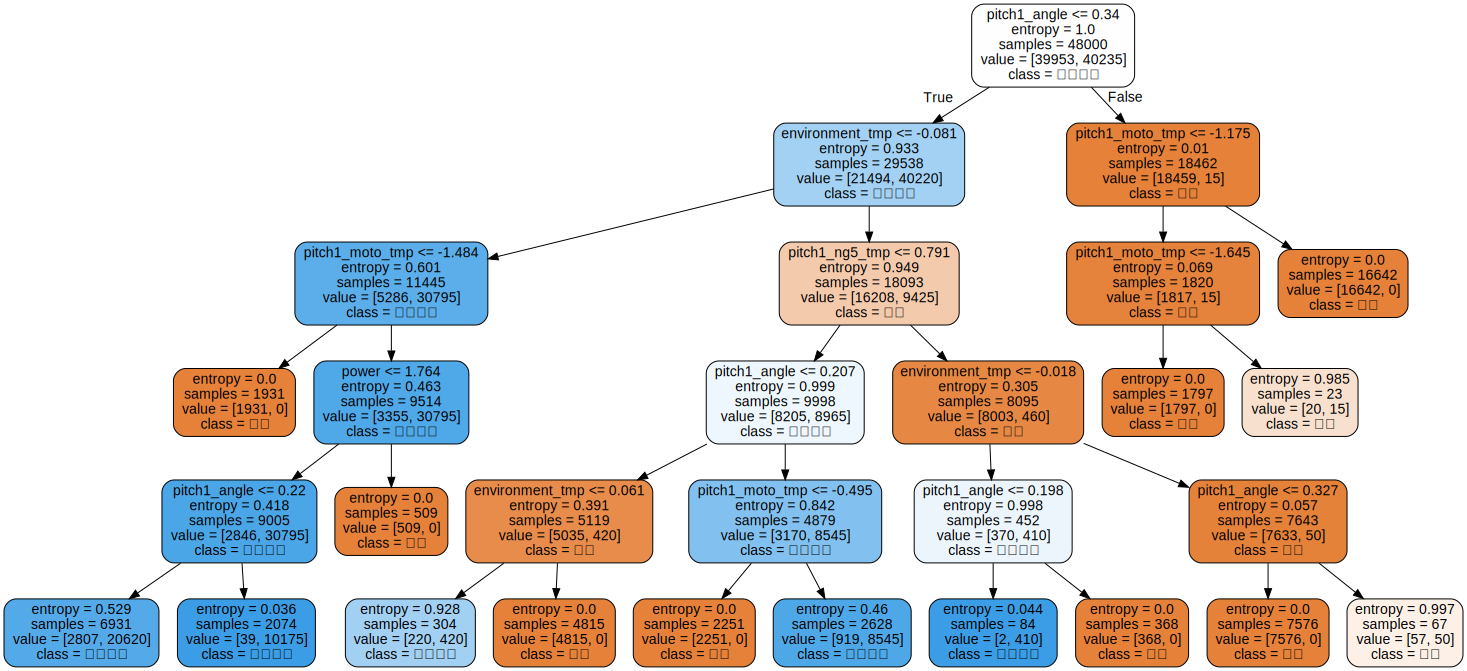

In [76]:
# ID3决策树算法生成, 最大深度设为5
clf = tree.DecisionTreeClassifier(criterion='entropy',
                                  max_depth=5,
                                  class_weight={0:1, 1:5},
                                  min_samples_leaf=20)
clf.fit(X_train,y_train)

# 分析模型所得精度
score = clf.score(X_test, y_test)
print("模型精确度：",score*100,"%\n")

# graphviz决策树图生成
source = tree.export_graphviz(clf,
                              feature_names=feature,
                              out_file=None,
                              class_names=['正常','结冰故障'],
                              filled=True,
                              rounded=True)
graph = graphviz.Source(source)
graph  

CART决策树算法同上处理

模型精确度： 92.91666666666667 %



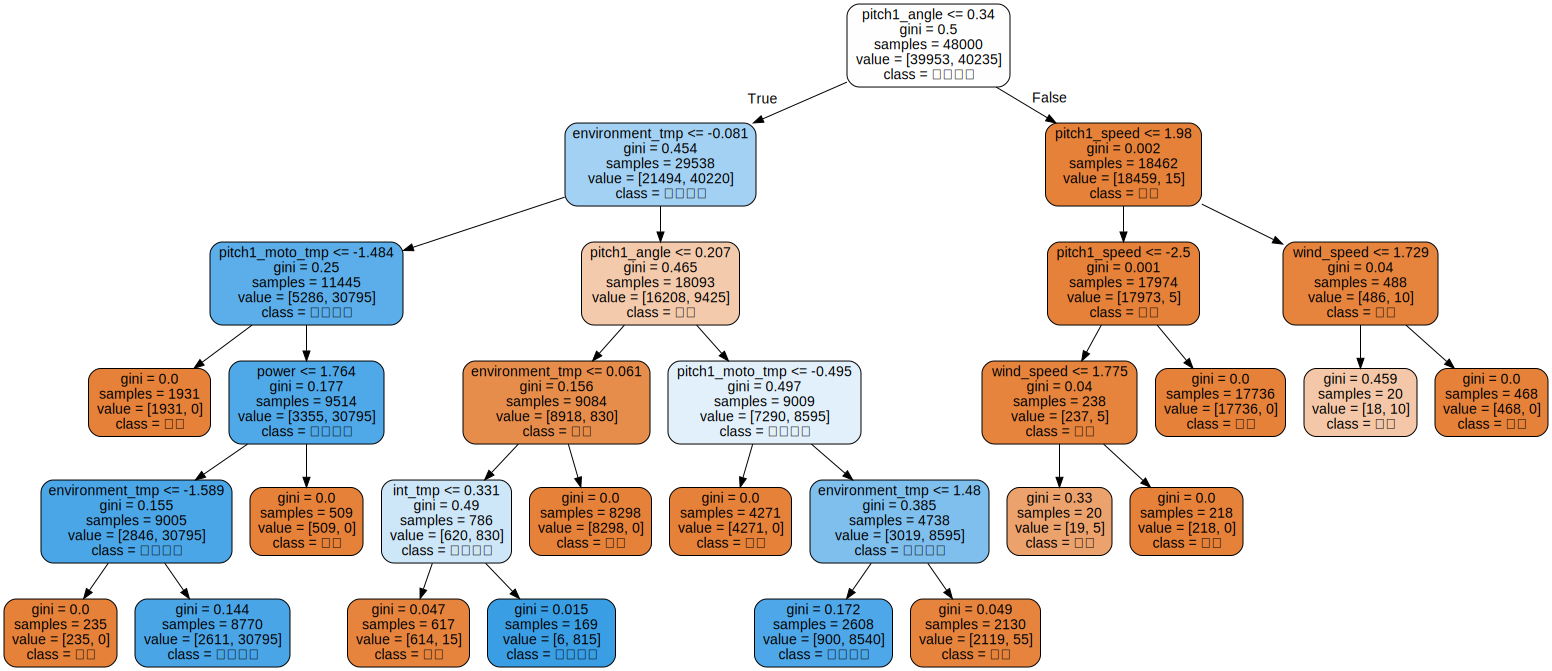

In [78]:
# CART决策树算法生成, 最大深度设为5
clf = tree.DecisionTreeClassifier(criterion='gini',
                                  max_depth=5,             # 设置树的最大深度，防止
                                  class_weight={0:1,1:5},
                                  min_samples_leaf=20)  # 设置权重，01类训练样本比为5:1
clf.fit(X_train,y_train)

# 分析模型所得精度
score = clf.score(X_test, y_test)
print("模型精确度：",score*100,"%\n")

# graphviz决策树图生成
source = tree.export_graphviz(clf,
                              feature_names=feature,
                              out_file=None,
                              class_names=['正常','结冰故障'],
                              filled=True,
                              rounded=True)
graph = graphviz.Source(source)
graph  

In [ ]:
# C4D决策树算法